In [3]:
import pennylane as qml
from pennylane import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score

# Data preparation
seismic_data = np.genfromtxt('seismic_trace_15_9_F-15-A.csv', delimiter=';')

time_seismic = -np.round(seismic_data[:, 0])
time_seismic, unique_indices = np.unique(time_seismic, return_index=True)
dt_seismic = time_seismic[1] - time_seismic[0]

seismic_trace = seismic_data[unique_indices, 1]
Ip_trace = seismic_data[unique_indices, 2]

start_time = 2340.0
end_time = 2500.0

seismic_trace_cropped = seismic_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
Ip_trace_cropped = Ip_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
time_cropped = time_seismic[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]

source_statistical = np.genfromtxt('statistical_source_wavelet.txt', delimiter='\t')
dt_source = 1e-3

# Data normalization
scaler_seismic = MinMaxScaler()
seismic_trace_cropped_normalized = scaler_seismic.fit_transform(seismic_trace_cropped.reshape(-1, 1)).flatten()

scaler_ip = MinMaxScaler()
Ip_trace_cropped_normalized = scaler_ip.fit_transform(Ip_trace_cropped.reshape(-1, 1)).flatten()



Iteration 5: Cost = 70.5054
Iteration 10: Cost = 69.2127
Iteration 15: Cost = 68.6765
Iteration 20: Cost = 68.3879


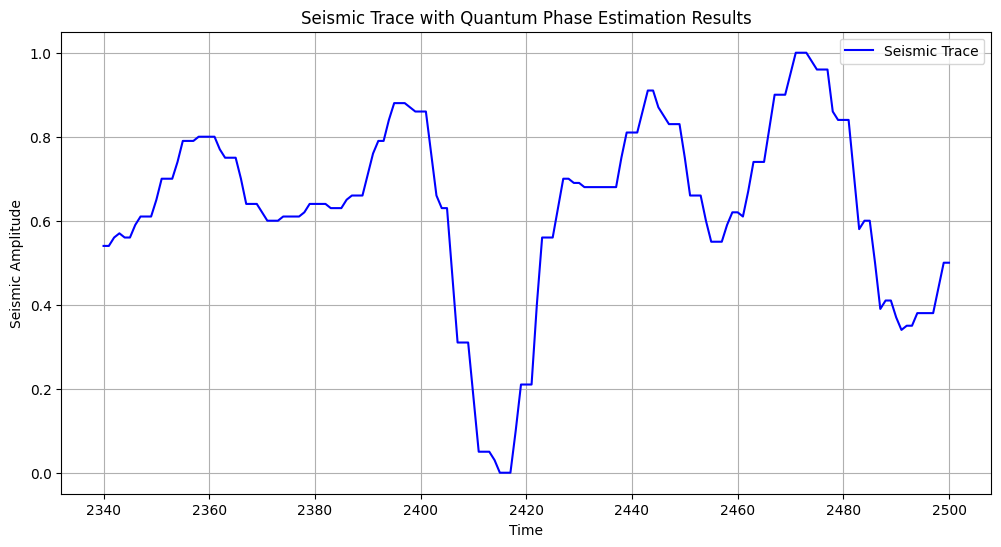

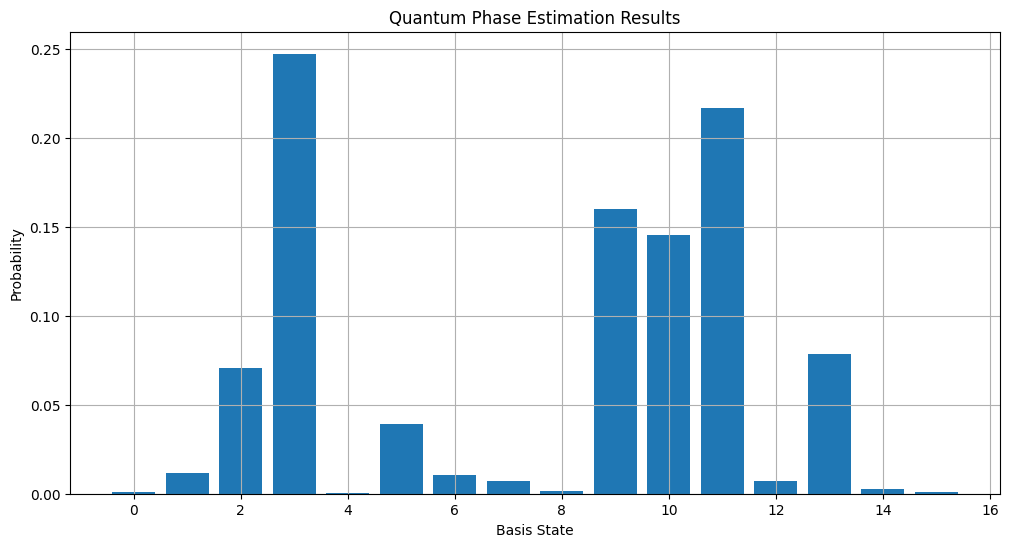

In [8]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess seismic data
seismic_data = np.genfromtxt('seismic_trace_15_9_F-15-A.csv', delimiter=';')

time_seismic = -np.round(seismic_data[:, 0])
time_seismic, unique_indices = np.unique(time_seismic, return_index=True)
dt_seismic = time_seismic[1] - time_seismic[0]

seismic_trace = seismic_data[unique_indices, 1]
Ip_trace = seismic_data[unique_indices, 2]

start_time = 2340.0
end_time = 2500.0

# Crop and normalize data
seismic_trace_cropped = seismic_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
Ip_trace_cropped = Ip_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
time_cropped = time_seismic[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]

scaler_seismic = MinMaxScaler()
seismic_trace_cropped_normalized = scaler_seismic.fit_transform(seismic_trace_cropped.reshape(-1, 1)).flatten()

scaler_ip = MinMaxScaler()
Ip_trace_cropped_normalized = scaler_ip.fit_transform(Ip_trace_cropped.reshape(-1, 1)).flatten()

# Create PyTorch tensors and DataLoader
seismic_tensor = torch.tensor(seismic_trace_cropped_normalized, dtype=torch.float32)
Ip_tensor = torch.tensor(Ip_trace_cropped_normalized, dtype=torch.float32)

dataset = TensorDataset(seismic_tensor, Ip_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define Quantum Phase Estimation (QPE) parameters and functions
n_wires = 4  # Define the number of wires
dev = qml.device("default.qubit", wires=n_wires)

def qpe_circuit(angles):
    # Apply Hadamard gates to all wires
    for i in range(n_wires):
        qml.Hadamard(wires=i)

    # Apply phase shift gates
    for i in range(n_wires):
        qml.RZ(angles[i], wires=i)

    # Apply Inverse Quantum Fourier Transform manually
    for i in range(n_wires):
        for j in range(i + 1, n_wires):
            qml.CRX(2 * np.pi / (2 ** (j - i + 1)), wires=[j, i])
        qml.Hadamard(wires=i)

    return qml.probs(wires=range(n_wires))

@qml.qnode(dev)
def qpe_experiment(angles):
    return qpe_circuit(angles)

# Define cost function
def phase_estimation_cost(angles):
    return -np.sum(np.log(qpe_experiment(angles) + 1e-10))

# Initialize angles randomly
np.random.seed(42)
angles = np.random.uniform(0, 2 * np.pi, n_wires)

# Optimize the angles
opt = qml.AdagradOptimizer(stepsize=0.1)
for i in range(20):
    angles, cost = opt.step_and_cost(phase_estimation_cost, angles)
    if (i + 1) % 5 == 0:
        print(f"Iteration {i + 1}: Cost = {cost:.4f}")

# Plot the results
def plot_seismic_trace_with_qpe_results():
    plt.figure(figsize=(12, 6))
    plt.plot(time_cropped, seismic_trace_cropped, label='Seismic Trace', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Seismic Amplitude')
    plt.title('Seismic Trace with Quantum Phase Estimation Results')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_seismic_trace_with_qpe_results()

# Compare Quantum Phase Estimation Results
def plot_qpe_results():
    probabilities = qpe_experiment(angles)
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(probabilities)), probabilities)
    plt.xlabel('Basis State')
    plt.ylabel('Probability')
    plt.title('Quantum Phase Estimation Results')
    plt.grid(True)
    plt.show()

plot_qpe_results()

# Save results
np.savetxt('qpe_angles.txt', angles)
np.savetxt('qpe_probabilities.txt', qpe_experiment(angles))


Iteration 5: Cost = 70.5054
Iteration 10: Cost = 69.2127
Iteration 15: Cost = 68.6765
Iteration 20: Cost = 68.3879


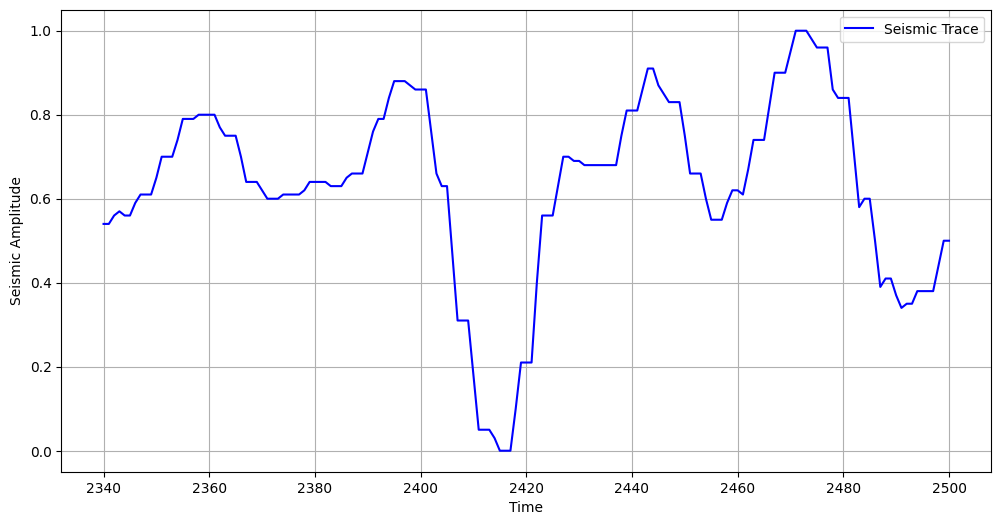

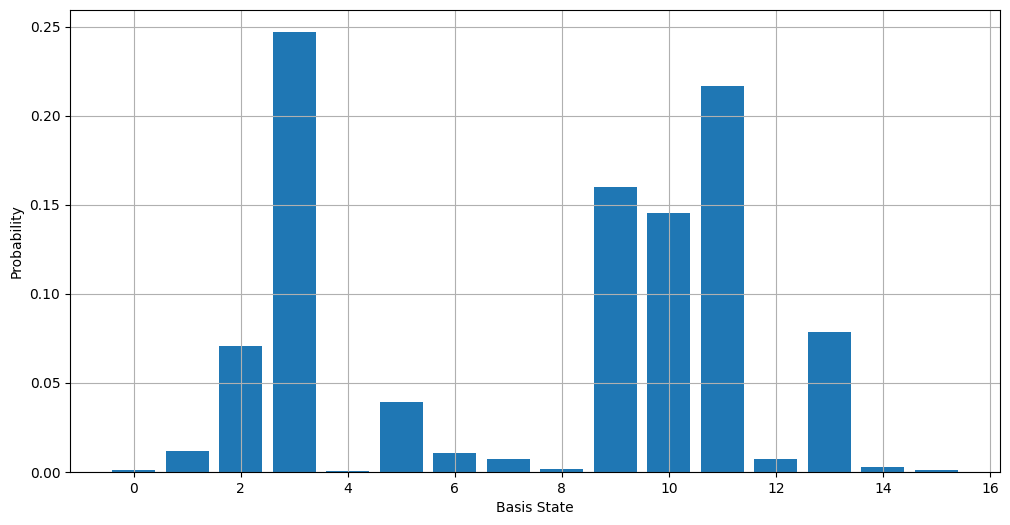

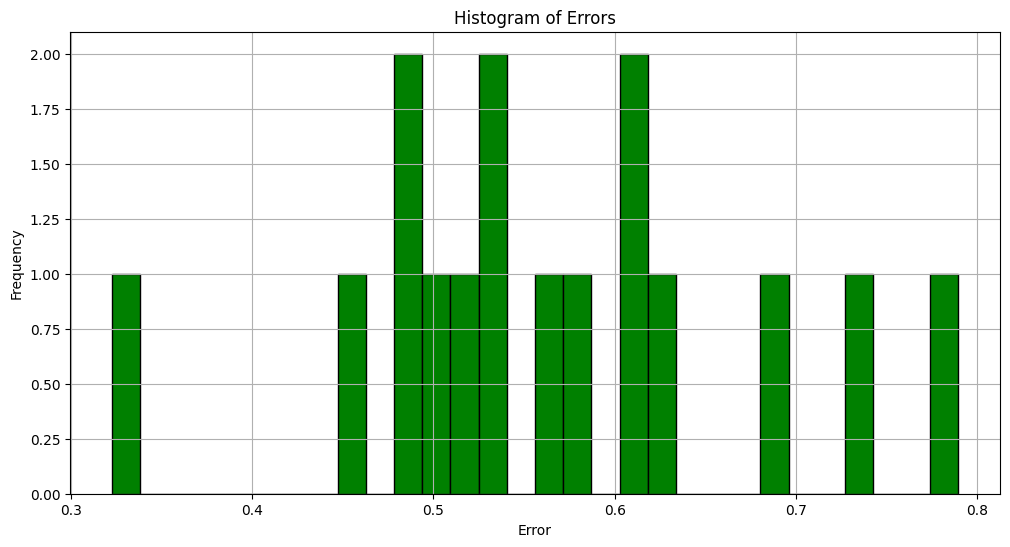

Mean Squared Error (MSE): 0.3307
R-squared (R^2): -57.8276


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load and preprocess seismic data
seismic_data = np.genfromtxt('seismic_trace_15_9_F-15-A.csv', delimiter=';')

time_seismic = -np.round(seismic_data[:, 0])
time_seismic, unique_indices = np.unique(time_seismic, return_index=True)
dt_seismic = time_seismic[1] - time_seismic[0]

seismic_trace = seismic_data[unique_indices, 1]
Ip_trace = seismic_data[unique_indices, 2]

start_time = 2340.0
end_time = 2500.0

# Crop and normalize data
seismic_trace_cropped = seismic_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
Ip_trace_cropped = Ip_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
time_cropped = time_seismic[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]

scaler_seismic = MinMaxScaler()
seismic_trace_cropped_normalized = scaler_seismic.fit_transform(seismic_trace_cropped.reshape(-1, 1)).flatten()

scaler_ip = MinMaxScaler()
Ip_trace_cropped_normalized = scaler_ip.fit_transform(Ip_trace_cropped.reshape(-1, 1)).flatten()

# Create PyTorch tensors and DataLoader
seismic_tensor = torch.tensor(seismic_trace_cropped_normalized, dtype=torch.float32)
Ip_tensor = torch.tensor(Ip_trace_cropped_normalized, dtype=torch.float32)

dataset = TensorDataset(seismic_tensor, Ip_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define Quantum Phase Estimation (QPE) parameters and functions
n_wires = 4  # Define the number of wires
dev = qml.device("default.qubit", wires=n_wires)

def qpe_circuit(angles):
    # Apply Hadamard gates to all wires
    for i in range(n_wires):
        qml.Hadamard(wires=i)

    # Apply phase shift gates
    for i in range(n_wires):
        qml.RZ(angles[i], wires=i)

    # Apply Inverse Quantum Fourier Transform manually
    for i in range(n_wires):
        for j in range(i + 1, n_wires):
            qml.CRX(2 * np.pi / (2 ** (j - i + 1)), wires=[j, i])
        qml.Hadamard(wires=i)

    return qml.probs(wires=range(n_wires))

@qml.qnode(dev)
def qpe_experiment(angles):
    return qpe_circuit(angles)

# Define cost function
def phase_estimation_cost(angles):
    return -np.sum(np.log(qpe_experiment(angles) + 1e-10))

# Initialize angles randomly
np.random.seed(42)
angles = np.random.uniform(0, 2 * np.pi, n_wires)

# Optimize the angles
opt = qml.AdagradOptimizer(stepsize=0.1)
for i in range(20):
    angles, cost = opt.step_and_cost(phase_estimation_cost, angles)
    if (i + 1) % 5 == 0:
        print(f"Iteration {i + 1}: Cost = {cost:.4f}")

# Plot the results
def plot_seismic_trace_with_qpe_results():
    plt.figure(figsize=(12, 6))
    plt.plot(time_cropped, seismic_trace_cropped, label='Seismic Trace', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Seismic Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_seismic_trace_with_qpe_results()

# Compare Quantum Phase Estimation Results
def plot_qpe_results():
    probabilities = qpe_experiment(angles)
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(probabilities)), probabilities)
    plt.xlabel('Basis State')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.show()

plot_qpe_results()

# Save results
np.savetxt('qpe_angles.txt', angles)
np.savetxt('qpe_probabilities.txt', qpe_experiment(angles))

# Additional Post-Processing

# Compute and plot error histogram
def plot_error_histogram():
    qpe_probabilities = qpe_experiment(angles)

    # Interpolate the actual probabilities to match the QPE probabilities
    interpolated_probabilities = np.interp(np.arange(len(qpe_probabilities)),
                                           np.arange(len(seismic_trace_cropped_normalized)),
                                           seismic_trace_cropped_normalized)

    errors = interpolated_probabilities - qpe_probabilities
    plt.figure(figsize=(12, 6))
    plt.hist(errors, bins=30, color='green', edgecolor='black')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Histogram of Errors')
    plt.grid(True)
    plt.show()

plot_error_histogram()

# Compute metrics
def compute_metrics():
    qpe_probabilities = qpe_experiment(angles)
    interpolated_probabilities = np.interp(np.arange(len(qpe_probabilities)),
                                           np.arange(len(seismic_trace_cropped_normalized)),
                                           seismic_trace_cropped_normalized)

    mse = mean_squared_error(interpolated_probabilities, qpe_probabilities)
    r2 = r2_score(interpolated_probabilities, qpe_probabilities)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R^2): {r2:.4f}")

compute_metrics()


Iteration 5: Cost = 70.5054
Iteration 10: Cost = 69.2127
Iteration 15: Cost = 68.6765
Iteration 20: Cost = 68.3879


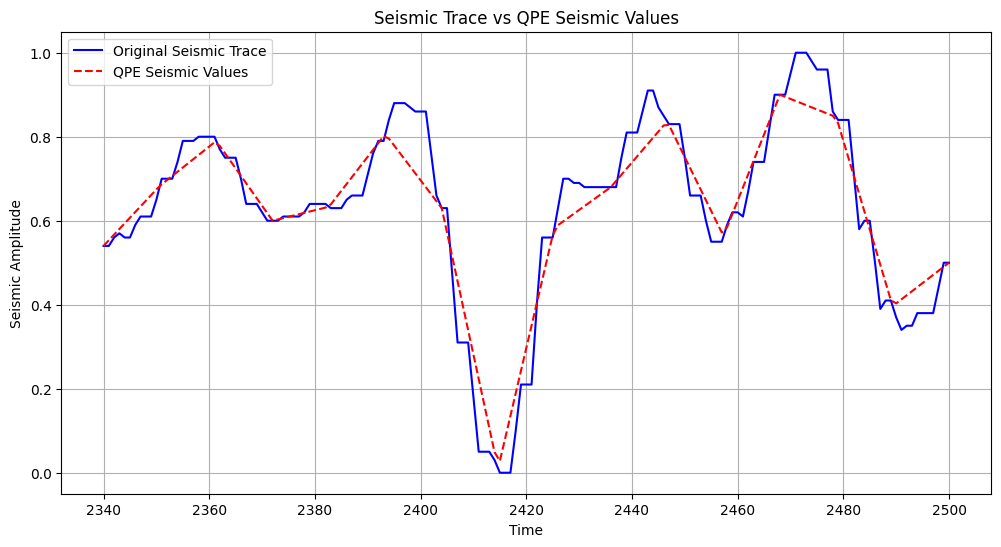

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load and preprocess seismic data
seismic_data = np.genfromtxt('seismic_trace_15_9_F-15-A.csv', delimiter=';')

time_seismic = -np.round(seismic_data[:, 0])
time_seismic, unique_indices = np.unique(time_seismic, return_index=True)
dt_seismic = time_seismic[1] - time_seismic[0]

seismic_trace = seismic_data[unique_indices, 1]
Ip_trace = seismic_data[unique_indices, 2]

start_time = 2340.0
end_time = 2500.0

# Crop and normalize data
seismic_trace_cropped = seismic_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
Ip_trace_cropped = Ip_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
time_cropped = time_seismic[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]

scaler_seismic = MinMaxScaler()
seismic_trace_cropped_normalized = scaler_seismic.fit_transform(seismic_trace_cropped.reshape(-1, 1)).flatten()

scaler_ip = MinMaxScaler()
Ip_trace_cropped_normalized = scaler_ip.fit_transform(Ip_trace_cropped.reshape(-1, 1)).flatten()

# Create PyTorch tensors and DataLoader
seismic_tensor = torch.tensor(seismic_trace_cropped_normalized, dtype=torch.float32)
Ip_tensor = torch.tensor(Ip_trace_cropped_normalized, dtype=torch.float32)

dataset = TensorDataset(seismic_tensor, Ip_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# Define Quantum Phase Estimation (QPE) parameters and functions
n_wires = 4  # Define the number of wires
dev = qml.device("default.qubit", wires=n_wires)

def qpe_circuit(angles):
    # Apply Hadamard gates to all wires
    for i in range(n_wires):
        qml.Hadamard(wires=i)

    # Apply phase shift gates
    for i in range(n_wires):
        qml.RZ(angles[i], wires=i)

    # Apply Inverse Quantum Fourier Transform manually
    for i in range(n_wires):
        for j in range(i + 1, n_wires):
            qml.CRX(2 * np.pi / (2 ** (j - i + 1)), wires=[j, i])
        qml.Hadamard(wires=i)

    return qml.probs(wires=range(n_wires))

@qml.qnode(dev)
def qpe_experiment(angles):
    return qpe_circuit(angles)

# Define cost function
def phase_estimation_cost(angles):
    return -np.sum(np.log(qpe_experiment(angles) + 1e-10))

# Initialize angles randomly
np.random.seed(42)
angles = np.random.uniform(0, 2 * np.pi, n_wires)

# Optimize the angles
opt = qml.AdagradOptimizer(stepsize=0.1)
for i in range(20):
    angles, cost = opt.step_and_cost(phase_estimation_cost, angles)
    if (i + 1) % 5 == 0:
        print(f"Iteration {i + 1}: Cost = {cost:.4f}")

# Compute QPE probabilities
qpe_probabilities = qpe_experiment(angles)

# Map QPE probabilities to seismic values
def map_qpe_to_seismic(qpe_probabilities, seismic_trace):
    num_probabilities = len(qpe_probabilities)

    # Generate an array of indices for interpolation
    indices = np.linspace(0, len(seismic_trace) - 1, num_probabilities)

    # Interpolate seismic trace values based on the indices
    seismic_values_interpolated = np.interp(indices, np.arange(len(seismic_trace)), seismic_trace)

    # Map QPE probabilities to the seismic values using interpolation
    qpe_seismic_values = np.interp(np.linspace(0, 1, num_probabilities), np.linspace(0, 1, len(seismic_values_interpolated)), seismic_values_interpolated)

    return qpe_seismic_values

# Get the QPE seismic values
qpe_seismic_values = map_qpe_to_seismic(qpe_probabilities, seismic_trace_cropped)

#
if len(qpe_seismic_values) != len(time_cropped):
    # Interpolate to match sizes
    qpe_seismic_values = np.interp(np.linspace(0, len(qpe_seismic_values) - 1, len(time_cropped)),
                                   np.arange(len(qpe_seismic_values)), qpe_seismic_values)

# Plot original and QPE seismic values
def plot_seismic_vs_qpe_seismic(seismic_trace, qpe_seismic_values, time_cropped):
    plt.figure(figsize=(12, 6))
    plt.plot(time_cropped, seismic_trace, label='Original Seismic Trace', color='blue')
    plt.plot(time_cropped, qpe_seismic_values, label='QPE Seismic Values', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Seismic Amplitude')
    plt.title('Seismic Trace vs QPE Seismic Values')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_seismic_vs_qpe_seismic(seismic_trace_cropped, qpe_seismic_values, time_cropped)


Iteration 5: Cost = 70.5054
Iteration 10: Cost = 69.2127
Iteration 15: Cost = 68.6765
Iteration 20: Cost = 68.3879
QPE Seismic Values:
[0.54       0.5534375  0.566875   0.5803125  0.59375    0.6071875
 0.620625   0.6340625  0.6475     0.6609375  0.674375   0.68666667
 0.69666667 0.70666667 0.71666667 0.72666667 0.73666667 0.74666667
 0.75666667 0.76666667 0.77666667 0.78666667 0.778125   0.7603125
 0.7425     0.7246875  0.706875   0.6890625  0.67125    0.6534375
 0.635625   0.6178125  0.6        0.603125   0.60625    0.609375
 0.6125     0.615625   0.61875    0.621875   0.625      0.628125
 0.63125    0.63875    0.655      0.67125    0.6875     0.70375
 0.72       0.73625    0.7525     0.76875    0.785      0.80125
 0.795625   0.7790625  0.7625     0.7459375  0.729375   0.7128125
 0.69625    0.6796875  0.663125   0.6465625  0.63       0.571875
 0.51375    0.455625   0.3975     0.339375   0.28125    0.223125
 0.165      0.106875   0.04875    0.02791667 0.08166667 0.13541667
 0.18916667 

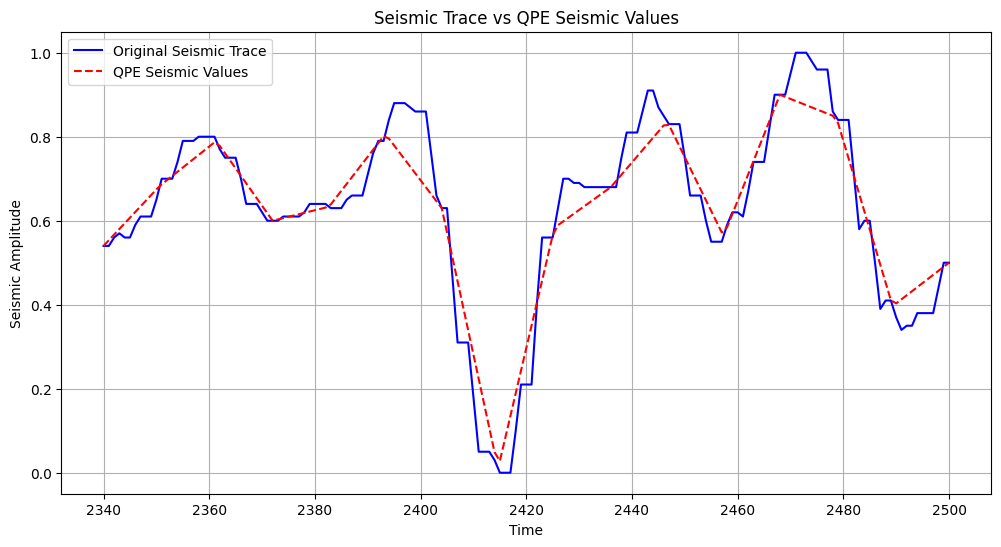

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess seismic data
seismic_data = np.genfromtxt('seismic_trace_15_9_F-15-A.csv', delimiter=';')

time_seismic = -np.round(seismic_data[:, 0])
time_seismic, unique_indices = np.unique(time_seismic, return_index=True)
dt_seismic = time_seismic[1] - time_seismic[0]

seismic_trace = seismic_data[unique_indices, 1]
Ip_trace = seismic_data[unique_indices, 2]

start_time = 2340.0
end_time = 2500.0

# Crop and normalize data
seismic_trace_cropped = seismic_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
Ip_trace_cropped = Ip_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
time_cropped = time_seismic[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]

scaler_seismic = MinMaxScaler()
seismic_trace_cropped_normalized = scaler_seismic.fit_transform(seismic_trace_cropped.reshape(-1, 1)).flatten()

scaler_ip = MinMaxScaler()
Ip_trace_cropped_normalized = scaler_ip.fit_transform(Ip_trace_cropped.reshape(-1, 1)).flatten()

# Create PyTorch tensors and DataLoader
seismic_tensor = torch.tensor(seismic_trace_cropped_normalized, dtype=torch.float32)
Ip_tensor = torch.tensor(Ip_trace_cropped_normalized, dtype=torch.float32)

dataset = TensorDataset(seismic_tensor, Ip_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define Quantum Phase Estimation (QPE) parameters and functions
n_wires = 4  # Define the number of wires
dev = qml.device("default.qubit", wires=n_wires)

def qpe_circuit(angles):
    # Apply Hadamard gates to all wires
    for i in range(n_wires):
        qml.Hadamard(wires=i)

    # Apply phase shift gates
    for i in range(n_wires):
        qml.RZ(angles[i], wires=i)

    # Apply Inverse Quantum Fourier Transform manually
    for i in range(n_wires):
        for j in range(i + 1, n_wires):
            qml.CRX(2 * np.pi / (2 ** (j - i + 1)), wires=[j, i])
        qml.Hadamard(wires=i)

    return qml.probs(wires=range(n_wires))

@qml.qnode(dev)
def qpe_experiment(angles):
    return qpe_circuit(angles)

# Define cost function
def phase_estimation_cost(angles):
    return -np.sum(np.log(qpe_experiment(angles) + 1e-10))

# Initialize angles randomly
np.random.seed(42)
angles = np.random.uniform(0, 2 * np.pi, n_wires)

# Optimize the angles
opt = qml.AdagradOptimizer(stepsize=0.1)
for i in range(20):
    angles, cost = opt.step_and_cost(phase_estimation_cost, angles)
    if (i + 1) % 5 == 0:
        print(f"Iteration {i + 1}: Cost = {cost:.4f}")

# Compute QPE probabilities
qpe_probabilities = qpe_experiment(angles)

# Map QPE probabilities to seismic values
def map_qpe_to_seismic(qpe_probabilities, seismic_trace):
    num_probabilities = len(qpe_probabilities)

    # Generate an array of indices for interpolation
    indices = np.linspace(0, len(seismic_trace) - 1, num_probabilities)

    # Interpolate seismic trace values based on the indices
    seismic_values_interpolated = np.interp(indices, np.arange(len(seismic_trace)), seismic_trace)

    # Map QPE probabilities to the seismic values using interpolation
    qpe_seismic_values = np.interp(np.linspace(0, 1, num_probabilities), np.linspace(0, 1, len(seismic_values_interpolated)), seismic_values_interpolated)

    return qpe_seismic_values

# Get the QPE seismic values
qpe_seismic_values = map_qpe_to_seismic(qpe_probabilities, seismic_trace_cropped)

# Adjust size of QPE seismic values to match time_cropped for plotting
if len(qpe_seismic_values) != len(time_cropped):
    # Interpolate to match sizes
    qpe_seismic_values = np.interp(np.linspace(0, len(qpe_seismic_values) - 1, len(time_cropped)),
                                   np.arange(len(qpe_seismic_values)), qpe_seismic_values)

# Print QPE seismic values
print("QPE Seismic Values:")
print(qpe_seismic_values)

# Plot original and QPE seismic values
def plot_seismic_vs_qpe_seismic(seismic_trace, qpe_seismic_values, time_cropped):
    plt.figure(figsize=(12, 6))
    plt.plot(time_cropped, seismic_trace, label='Original Seismic Trace', color='blue')
    plt.plot(time_cropped, qpe_seismic_values, label='QPE Seismic Values', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Seismic Amplitude')
    plt.title('Seismic Trace vs QPE Seismic Values')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_seismic_vs_qpe_seismic(seismic_trace_cropped, qpe_seismic_values, time_cropped)


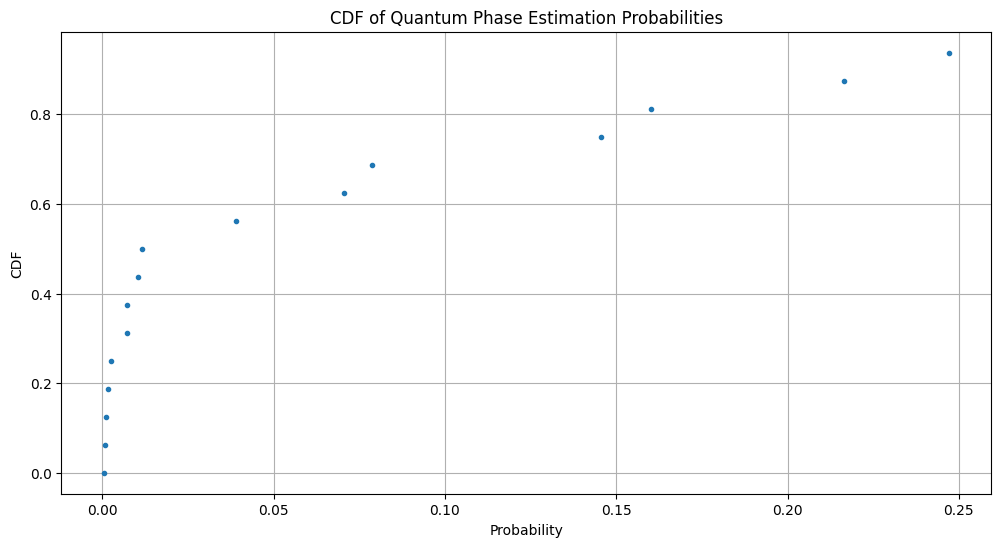

In [21]:
def plot_cdf(probabilities, title='Cumulative Distribution Function'):
    sorted_probs = np.sort(probabilities)
    cdf = np.arange(len(sorted_probs)) / float(len(sorted_probs))

    plt.figure(figsize=(12, 6))
    plt.plot(sorted_probs, cdf, marker='.', linestyle='none')
    plt.xlabel('Probability')
    plt.ylabel('CDF')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Plot CDF for QPE probabilities
plot_cdf(qpe_experiment(angles), title='CDF of Quantum Phase Estimation Probabilities')


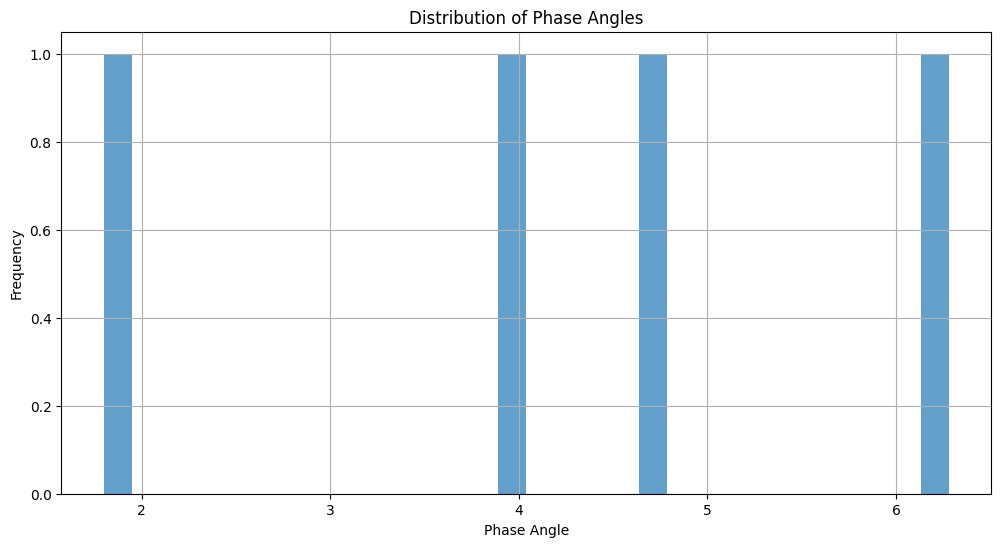

In [23]:
def plot_angle_distribution(angles):
    plt.figure(figsize=(12, 6))
    plt.hist(angles, bins=30, alpha=0.7)
    plt.xlabel('Phase Angle')
    plt.ylabel('Frequency')
    plt.title('Distribution of Phase Angles')
    plt.grid(True)
    plt.show()

plot_angle_distribution(angles)


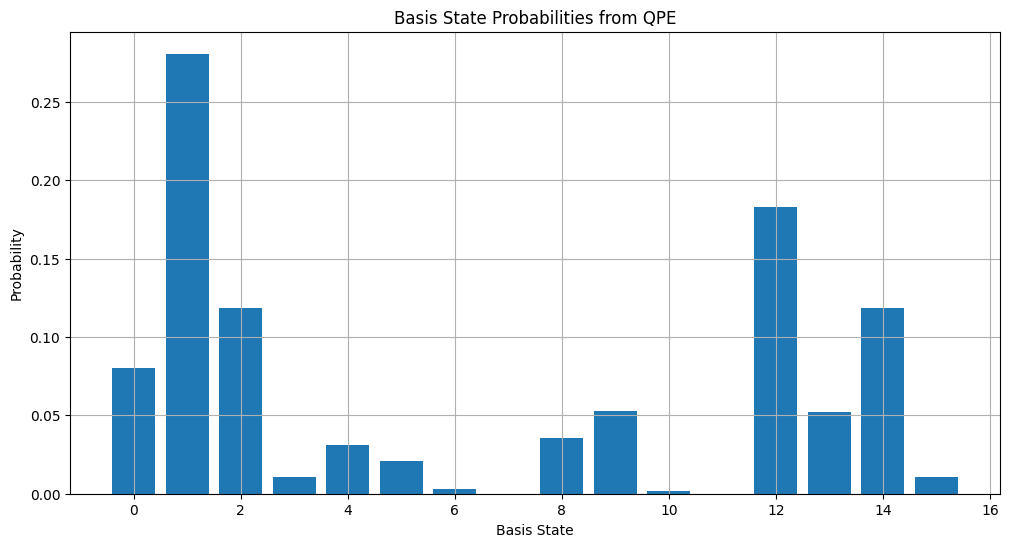

In [25]:
def plot_basis_state_probabilities(probabilities):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(probabilities)), probabilities)
    plt.xlabel('Basis State')
    plt.ylabel('Probability')
    plt.title('Basis State Probabilities from QPE')
    plt.grid(True)
    plt.show()

plot_basis_state_probabilities(qpe_experiment(angles))


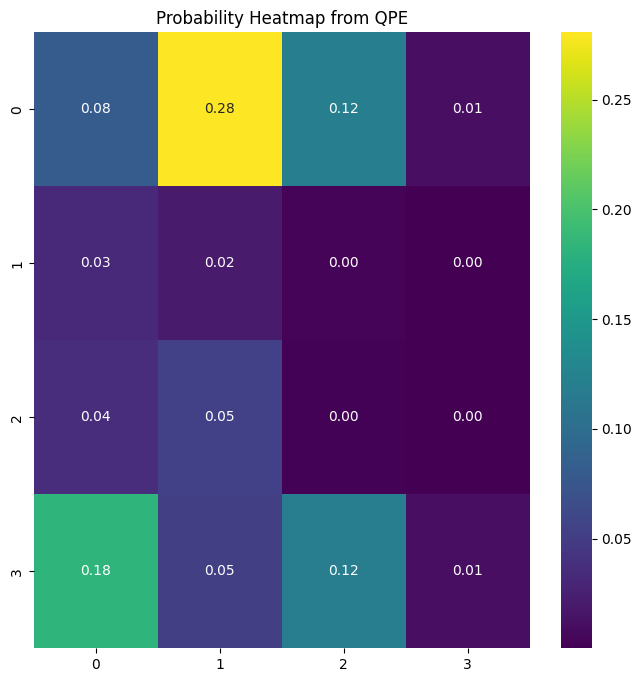

In [26]:
import seaborn as sns

def plot_probability_heatmap(probabilities):
    probs_matrix = np.reshape(probabilities, (int(np.sqrt(len(probabilities))), -1))
    plt.figure(figsize=(8, 8))
    sns.heatmap(probs_matrix, cmap='viridis', annot=True, fmt=".2f")
    plt.title('Probability Heatmap from QPE')
    plt.show()

plot_probability_heatmap(qpe_experiment(angles))


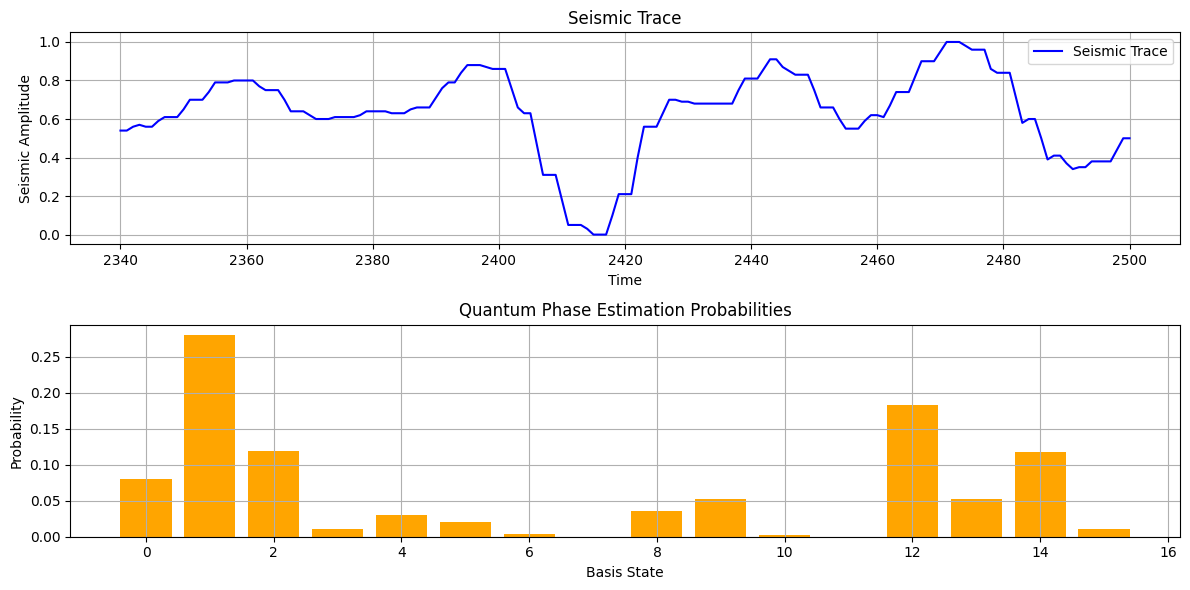

In [30]:
def plot_seismic_vs_qpe_probabilities(seismic_trace, qpe_probabilities, time_cropped):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(time_cropped, seismic_trace, label='Seismic Trace', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Seismic Amplitude')
    plt.title('Seismic Trace')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.bar(range(len(qpe_probabilities)), qpe_probabilities, color='orange')
    plt.xlabel('Basis State')
    plt.ylabel('Probability')
    plt.title('Quantum Phase Estimation Probabilities')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_seismic_vs_qpe_probabilities(seismic_trace_cropped, qpe_experiment(angles), time_cropped)


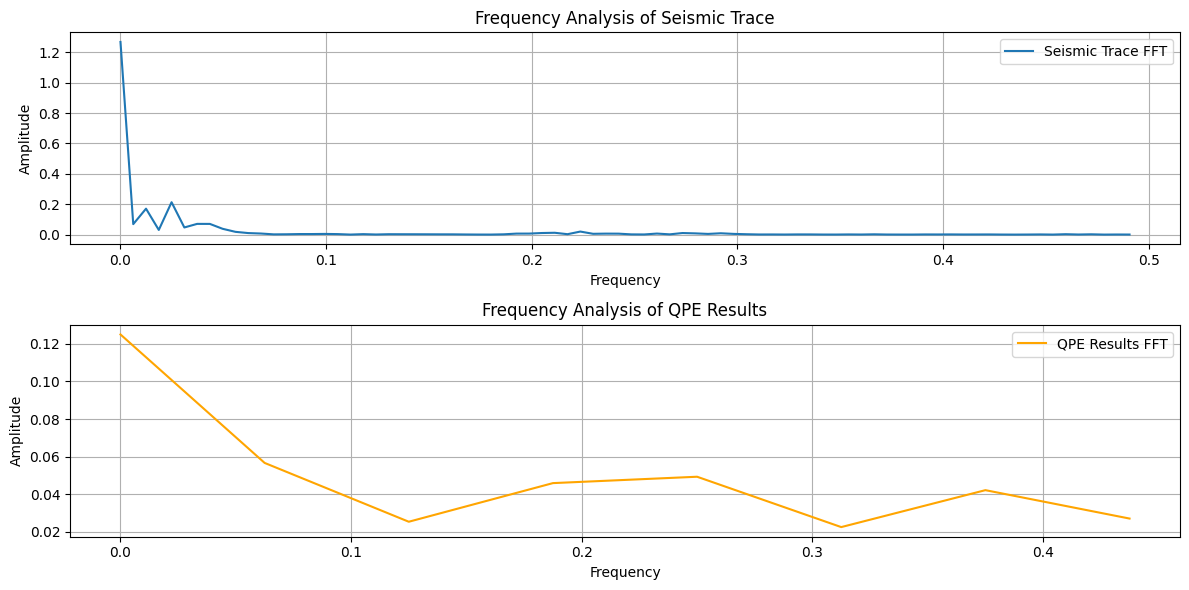

In [33]:
from scipy.fft import fft, fftfreq

def plot_seismic_trace_with_qpe_frequency_analysis(seismic_trace, qpe_probabilities, time_cropped):
    # Compute FFT of the seismic trace
    N = len(time_cropped)
    T = time_cropped[1] - time_cropped[0]
    yf = fft(seismic_trace)
    xf = fftfreq(N, T)[:N//2]

    # Compute FFT of the QPE results (if applicable)
    yf_qpe = fft(qpe_probabilities)
    xf_qpe = fftfreq(len(qpe_probabilities), 1)[:len(qpe_probabilities)//2]

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label='Seismic Trace FFT')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.title('Frequency Analysis of Seismic Trace')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(xf_qpe, 2.0/len(qpe_probabilities) * np.abs(yf_qpe[:len(qpe_probabilities)//2]), label='QPE Results FFT', color='orange')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.title('Frequency Analysis of QPE Results')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_seismic_trace_with_qpe_frequency_analysis(seismic_trace_cropped, qpe_experiment(angles), time_cropped)
